In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from scipy import integrate

In [2]:
def disparity_filter(G, weight='weight'):
    ''' Compute significance scores (alpha) for weighted edges in G as defined in Serrano et al. 2009
        Args
            G: Weighted NetworkX graph
        Returns
            Weighted graph with a significance score (alpha) assigned to each edge
        References
            M. A. Serrano et al. (2009) Extracting the Multiscale backbone of complex weighted networks. 
            PNAS, 106:16, pp. 6483-6488.
    '''
    
    if nx.is_directed(G): #directed case    
        N = nx.DiGraph()
        for u in G:
            
            k_out = G.out_degree(u)
            k_in = G.in_degree(u)
            
            if k_out > 1:
                sum_w_out = sum(np.absolute(G[u][v][weight]) for v in list(G.successors(u)))
                for v in list(G.successors(u)):
                    w = G[u][v][weight]
                    p_ij_out = float(np.absolute(w))/sum_w_out
                    alpha_ij_out = 1 - (k_out-1) * integrate.quad(lambda x: (1-x)**(k_out-2), 0, p_ij_out)[0]
                    N.add_edge(u, v, weight = w, alpha_out=float('%.4f' % alpha_ij_out))
                    
            elif k_out == 1 and G.in_degree(list(G.successors(u))[0]) == 1:
                #we need to keep the connection as it is the only way to maintain the connectivity of the network
                v = list(G.successors(u))[0]
                w = G[u][v][weight]
                N.add_edge(u, v, weight = w, alpha_out=0., alpha_in=0.)
                #there is no need to do the same for the k_in, since the link is built already from the tail
            
            if k_in > 1:
                sum_w_in = sum(np.absolute(G[v][u][weight]) for v in G.predecessors(u))
                for v in G.predecessors(u):
                    w = G[v][u][weight]
                    p_ij_in = float(np.absolute(w))/sum_w_in
                    alpha_ij_in = 1 - (k_in-1) * integrate.quad(lambda x: (1-x)**(k_in-2), 0, p_ij_in)[0]
                    N.add_edge(v, u, weight = w, alpha_in=float('%.4f' % alpha_ij_in))
        return N
    
    else: #undirected case
        B = nx.Graph()
        for u in G:
            k = len(G[u])
            if k > 1:
                sum_w = sum(np.absolute(G[u][v][weight]) for v in G[u])
                for v in G[u]:
                    w = G[u][v][weight]
                    p_ij = float(np.absolute(w))/sum_w
                    alpha_ij = 1 - (k-1) * integrate.quad(lambda x: (1-x)**(k-2), 0, p_ij)[0]
                    B.add_edge(u, v, weight = w, alpha=float('%.4f' % alpha_ij))
        return B

def disparity_filter_alpha_cut(G,weight='weight',alpha_t=0.4, cut_mode='or'):
    ''' Performs a cut of the graph previously filtered through the disparity_filter function.
        
        Args
        ----
        G: Weighted NetworkX graph
        
        weight: string (default='weight')
            Key for edge data used as the edge weight w_ij.
            
        alpha_t: double (default='0.4')
            The threshold for the alpha parameter that is used to select the surviving edges.
            It has to be a number between 0 and 1.
            
        cut_mode: string (default='or')
            Possible strings: 'or', 'and'.
            It works only for directed graphs. It represents the logic operation to filter out edges
            that do not pass the threshold value, combining the alpha_in and alpha_out attributes
            resulting from the disparity_filter function.
            
            
        Returns
        -------
        B: Weighted NetworkX graph
            The resulting graph contains only edges that survived from the filtering with the alpha_t threshold
    
        References
        ---------
        .. M. A. Serrano et al. (2009) Extracting the Multiscale backbone of complex weighted networks. PNAS, 
        106:16, pp. 6483-6488.
    '''    
    
    
    if nx.is_directed(G):#Directed case:   
        B = nx.DiGraph()
        for u, v, w in G.edges(data=True):
            try:
                alpha_in =  w['alpha_in']
            except KeyError: #there is no alpha_in, so we assign 1. It will never pass the cut
                alpha_in = 1
            try:
                alpha_out =  w['alpha_out']
            except KeyError: #there is no alpha_out, so we assign 1. It will never pass the cut
                alpha_out = 1  
            
            if cut_mode == 'or':
                if alpha_in<alpha_t or alpha_out<alpha_t:
                    B.add_edge(u,v, weight=w[weight])
            elif cut_mode == 'and':
                if alpha_in<alpha_t and alpha_out<alpha_t:
                    B.add_edge(u,v, weight=w[weight])
        return B

    else:
        B = nx.Graph()#Undirected case:   
        for u, v, w in G.edges(data=True):
            
            try:
                alpha = w['alpha']
            except KeyError: #there is no alpha, so we assign 1. It will never pass the cut
                alpha = 1
                
            if alpha<alpha_t:
                B.add_edge(u,v, weight=w[weight])
        return B                
            

In [105]:
def make_filtered_network(semester_weighted_el):
    D=nx.DiGraph()
    D.add_weighted_edges_from(semester_weighted_el[['source','destination','weight']].values)
    D=disparity_filter(D)

    filtered_graph=nx.Graph()
    filtered = [(x[0],x[1]) for x in D.edges(data=True) if
            x[2].get('alpha_out',1)<.1 and x[2].get('alpha_in',1)<.1]
    filtered_graph.add_edges_from(filtered)
    return filtered_graph

def get_collaborators_semester(semester):
    filtered_graph=make_filtered_network(semester_collab[semester_collab['semester_id']==semester])
    collabs=pd.DataFrame(filtered_graph.edges(),columns=['c1','c2'])
    return collabs
    
def get_country_collaborators(country,collaborations):
    collaborations_of_country =[]
    for row in collaborations.iterrows():
        if row[1].c1 == country:
            collaborations_of_country.append(row[1].c2)
        elif row[1].c2==country:
            collaborations_of_country.append(row[1].c1)
    return collaborations_of_country


In [21]:
el=pd.read_csv('../outputs/software_space_edgelist2020-2021.csv',sep=';')
country_lang_rca=pd.read_csv("../outputs/entry_table.csv",sep=";")

In [89]:
rca_dict=dict(
    country_lang_rca[country_lang_rca['rca01']==1].groupby(['iso2_code','semester_id']).language.apply(list))

In [25]:
df=pd.read_csv('../data/economy_collaborators.csv') #read in data
df=df[(df['source']!='EU')&(df['destination']!='EU')] #drop EU
df=df.sort_values(['year','quarter'])

df['semester']=df['quarter'].map(lambda x: 1 if x in [1,2] else 2)
df['semester_id']=df['year'].map(str)+'s'+df['semester'].map(str)

In [41]:
#for each country-semester
# get the collaborators
# get a list: country,language,semester, X = 1 if country C has neighbor with RCA >1 in language

In [84]:
semester_collab=df.groupby(['source','destination','semester_id'])['weight'].sum().reset_index()
semesters=sorted(semester_collab.semester_id.unique())
countries = list(set(list(df.source.unique())+list(df.destination.unique())))
languages = list(country_lang_rca['language'].unique())

In [119]:
output = [] #country,semester,collaborator,language RCA>1
all_csl_rca = [] #country,semester, language n RCA1
for semester in semesters:
    collabs=get_collaborators_semester(semester)
    for country in countries:
        collaborators=get_country_collaborators(country,collaborations = collabs)
        csl_rca = []
        if len(collaborators)>0:
            for collaborator in collaborators:
                if collaborator!=country:
                    langs=list(set(rca_dict.get((collaborator,semester),[])))
                    if len(langs)>0:
                        for lang in langs:
                            csl_rca.append((country,semester,lang))
                        output.append([country,semester,collaborator,langs])
        if len(csl_rca)>1:
            all_csl_rca+=list(set(csl_rca))
        

In [123]:
country_semester_neighbor_RCA_lang=pd.DataFrame(all_csl_rca,columns=['country','semester','neighbor_rca_lang'])

In [127]:
country_semester_neighbor_RCA_lang.to_csv('../outputs/country_semester_neighborRCA_langs.csv')

In [132]:
rel=pd.read_csv('../outputs/relatedness_country_semester_panel.csv')
rel.head(3)

,language,semester_id,iso2_code,rca01,rca_entry,rel_density,pci
0,AIDL,2020s1,AD,0,0,0.0,1.962936
1,AIDL,2020s1,AE,0,0,0.0,1.962936
2,AIDL,2020s1,AF,0,0,0.0,1.962936


In [145]:
cs_nl =dict(country_semester_neighbor_RCA_lang.groupby(['country','semester'])['neighbor_rca_lang'].apply(list))

In [148]:
neighbor_related = []
for row in rel.iterrows():
    rel_langs=cs_nl.get((row[1]['iso2_code'],row[1]['semester_id']),[])
    if row[1]['language'] in rel_langs:
        neighbor_related.append(1)
    else:
        neighbor_related.append(0)

In [150]:
rel['neighbor_related']=neighbor_related

In [159]:
!rm relatedness_country_semester_panel_with_collab_neighbors.csv

In [161]:
rel.to_csv('../outputs/relatedness_country_semester_panel_with_collab_neighbors.csv',index=None)

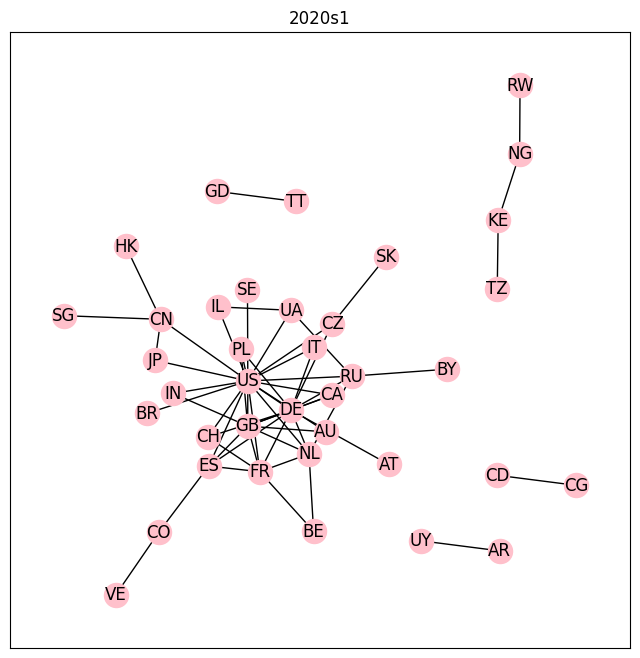

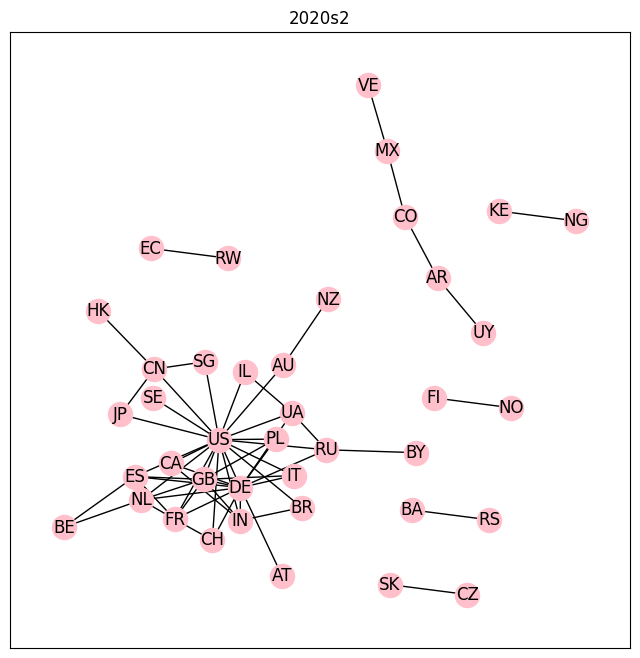

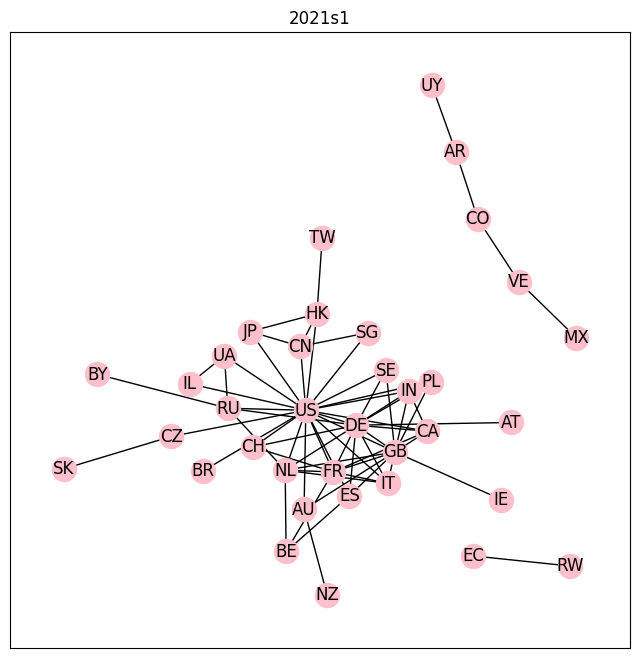

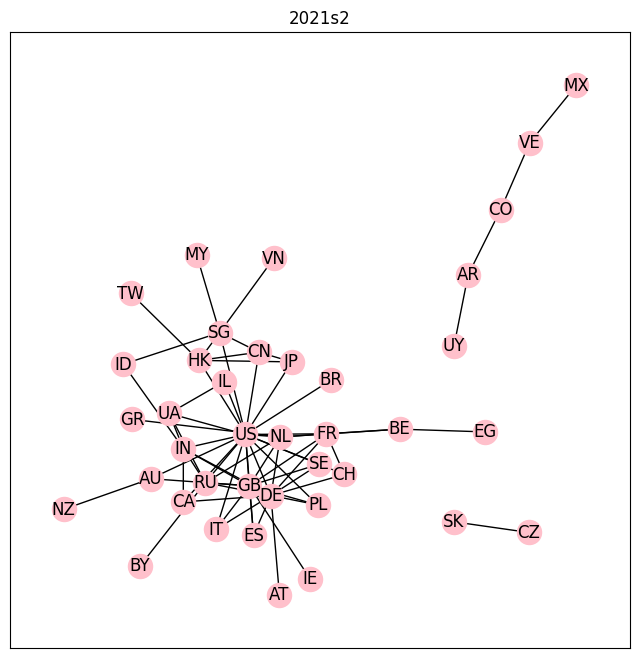

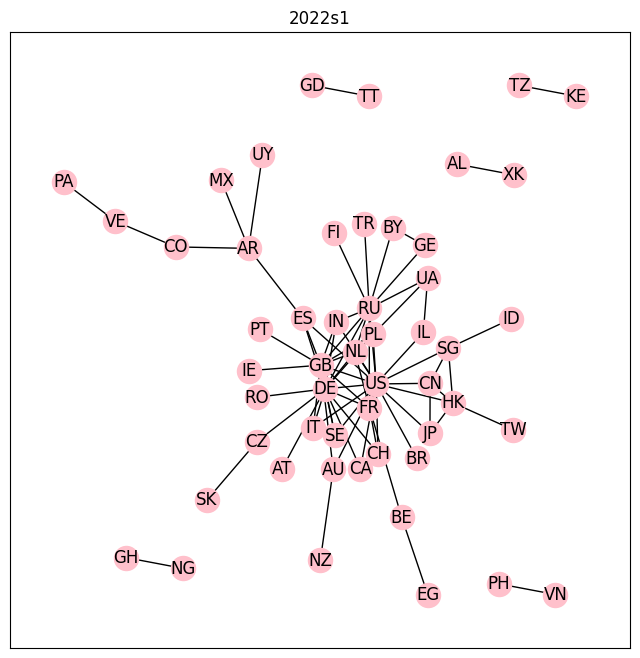

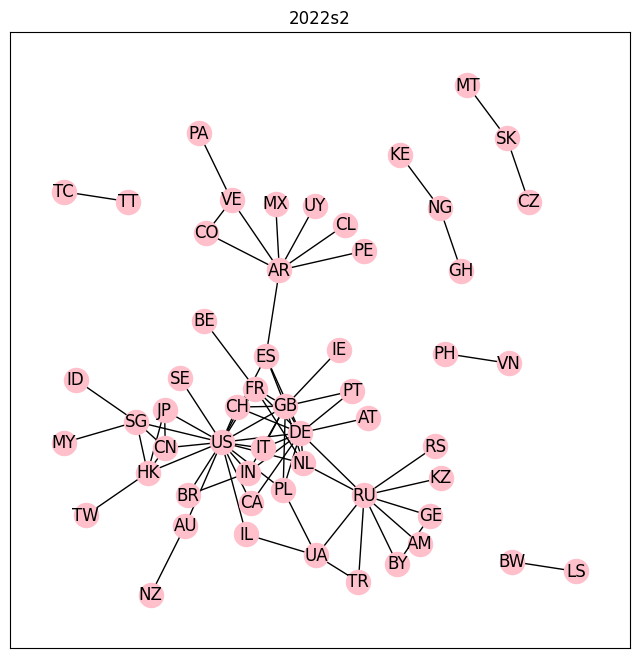

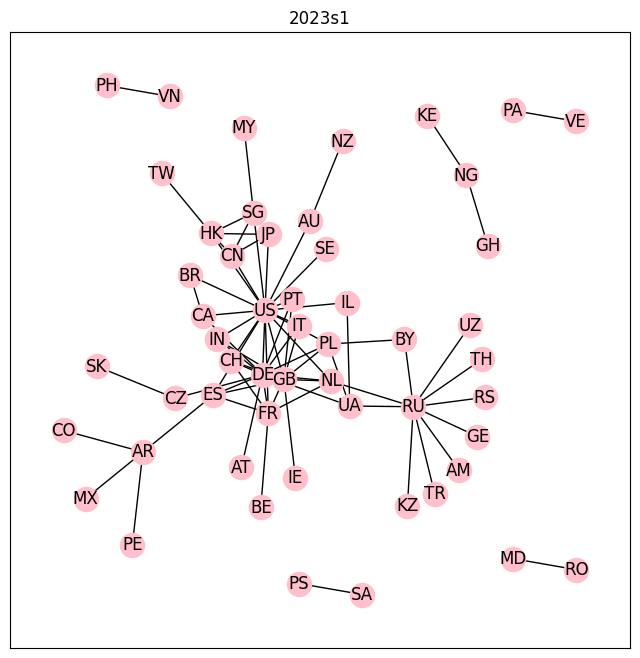

In [128]:
#plot
for semester in sorted(semester_collab.semester_id.unique()):
    mm=make_filtered_network(semester_collab[semester_collab['semester_id']==semester])
    pos=nx.nx_agraph.graphviz_layout(mm)
    plt.figure(figsize=(8,8))
    plt.title(semester)
    nx.draw_networkx(mm,pos=pos,node_color='pink')
    plt.show()

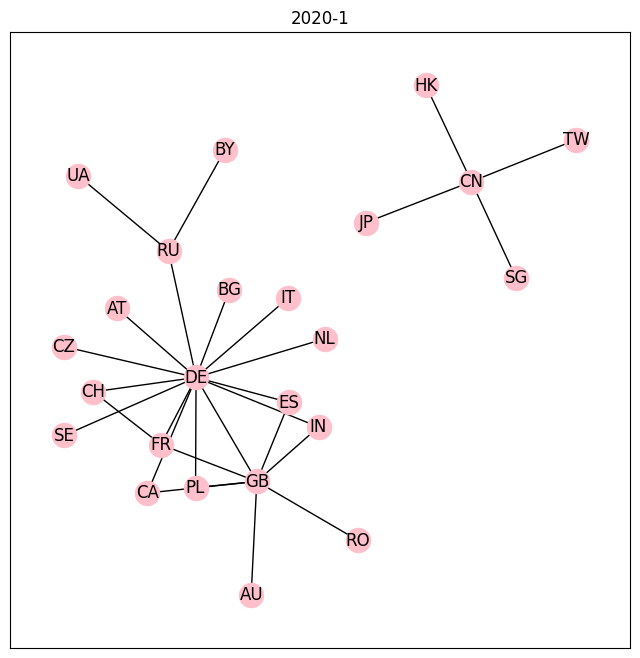

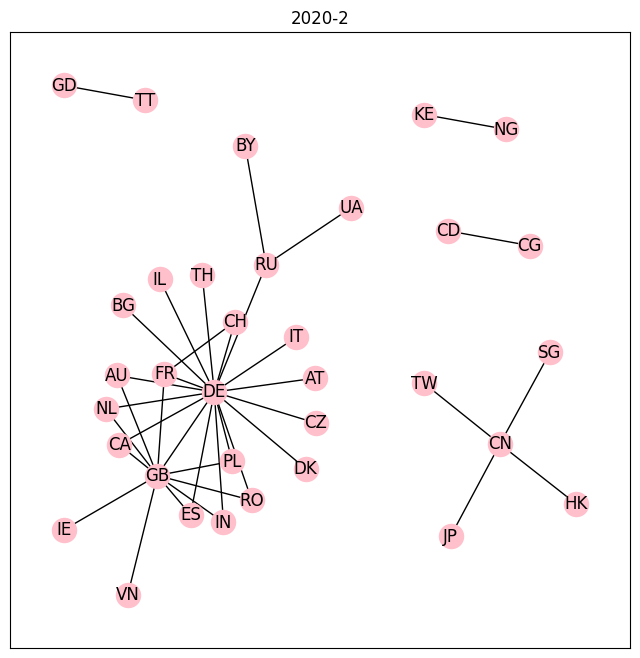

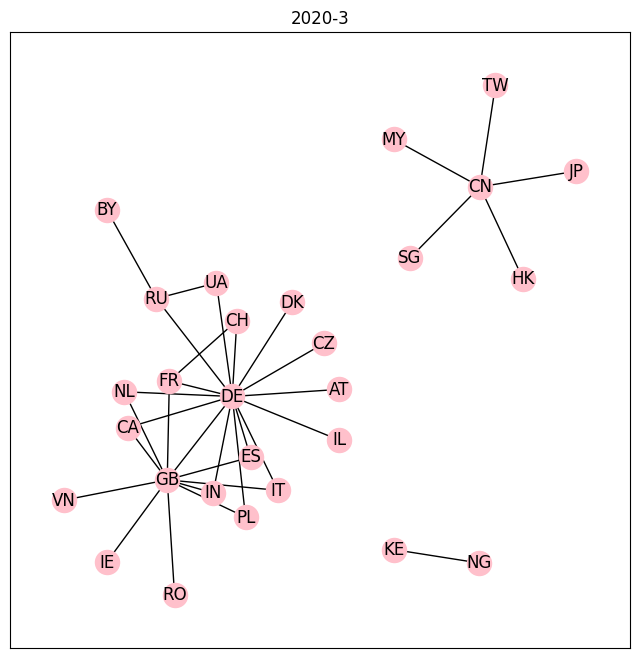

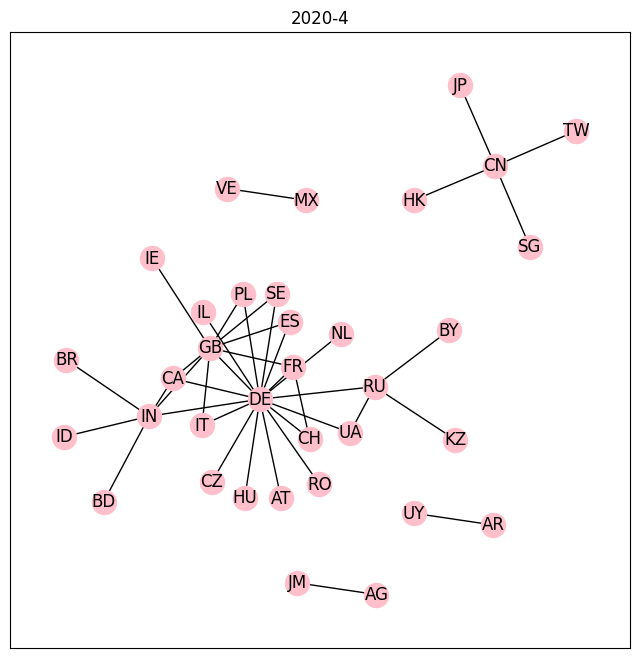

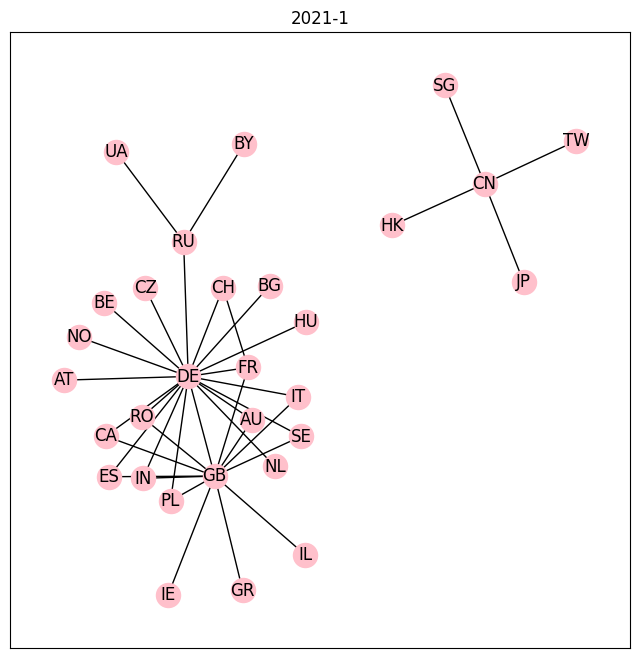

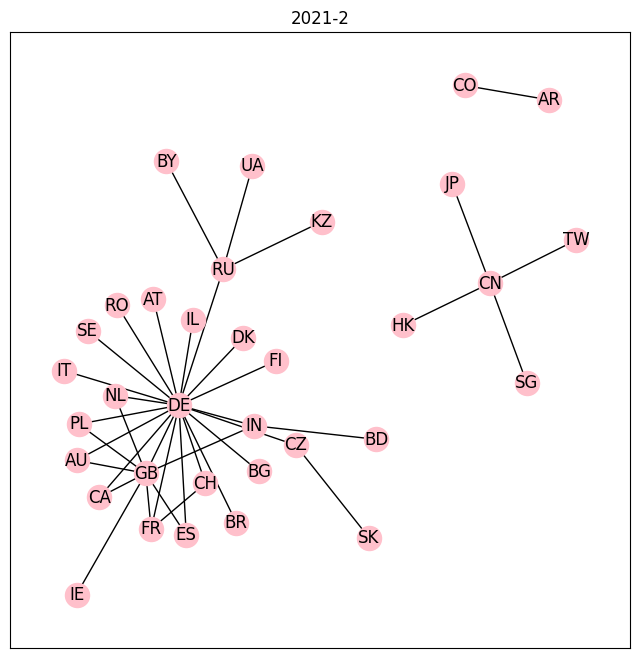

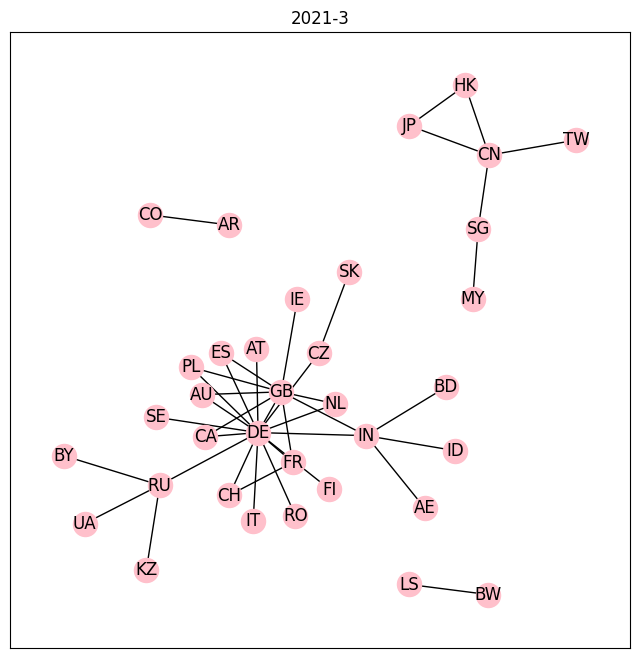

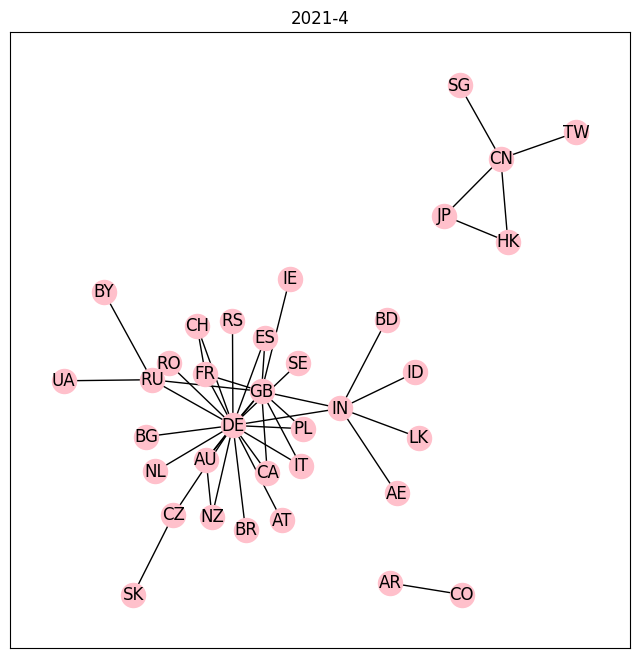

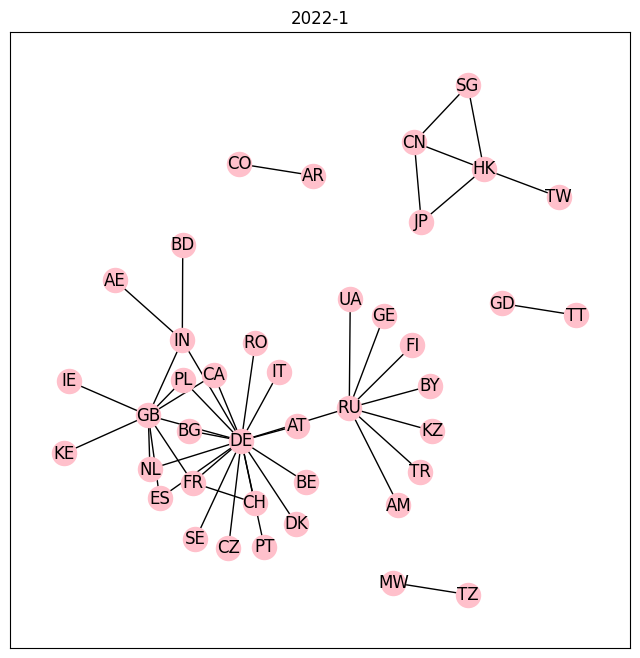

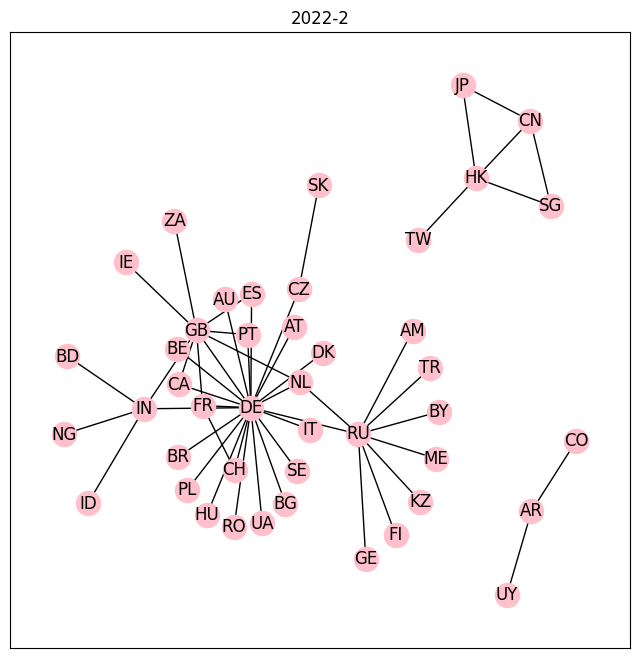

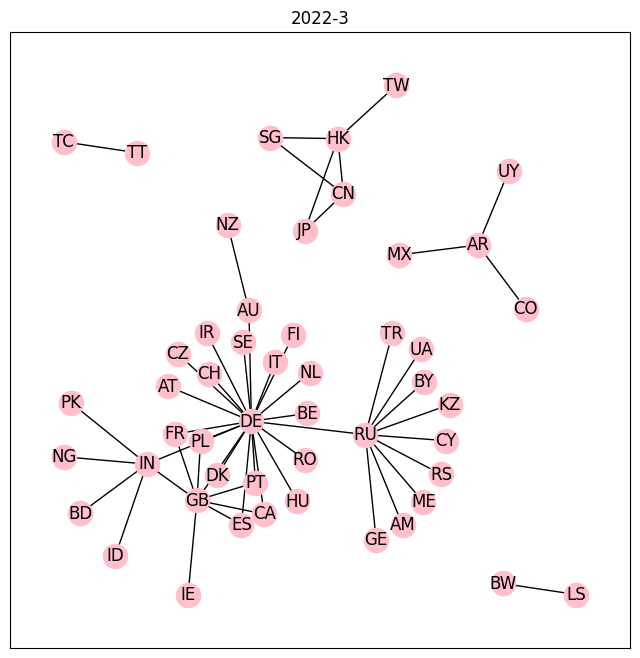

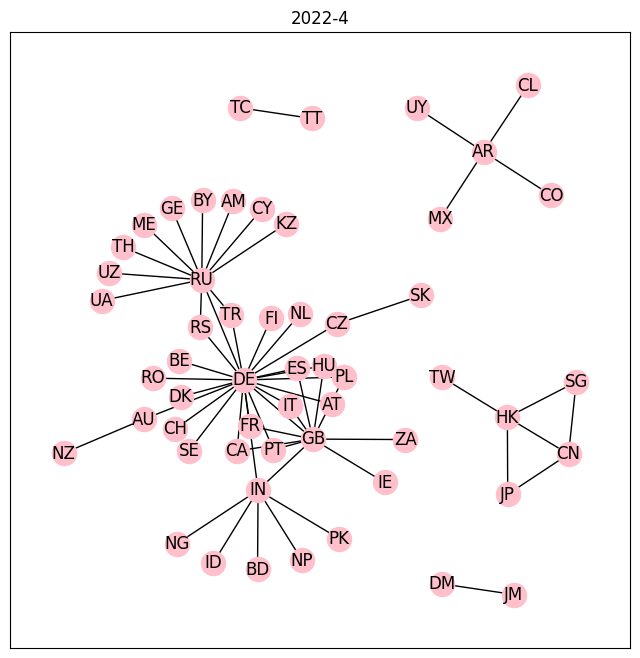

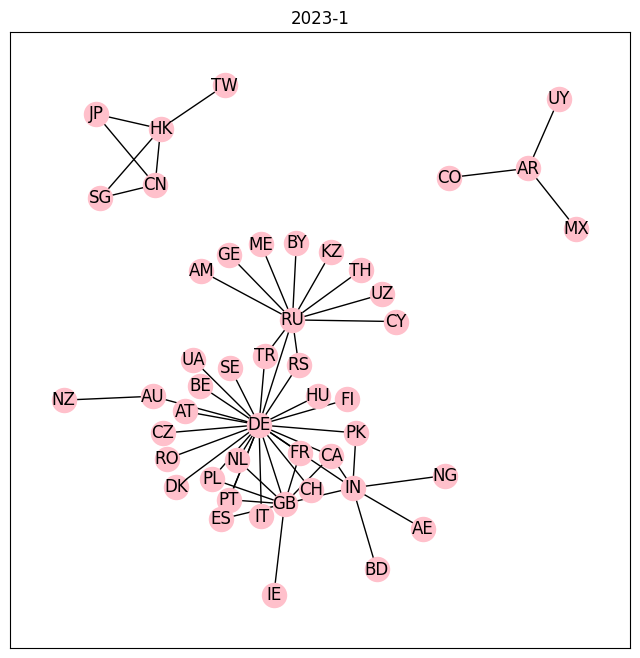

In [22]:

pr_scores = [] #list for pagerank scores

for year in df.year.unique():
    for quarter in df.quarter.unique():
        qdf = df[df['year']==year]
        qdf = qdf[qdf['quarter']==quarter]
        if len(qdf)>0:
            D=nx.DiGraph() #make directed network
            D.add_weighted_edges_from(qdf[['source','destination','weight']].values)
            pr=list(nx.pagerank(D).items())
            pr_scores+=[[year,quarter,x[0],x[1]] for x in pr] #dump pr scores
            
            #filter/draw
            D.remove_node('US')
            D=disparity_filter(D)

            DF=nx.Graph()
            filt = [
                (x[0],x[1]) for x in D.edges(data=True) if
                    x[2].get('alpha_out',1)<.05 and x[2].get('alpha_in',1)<.05]


            DF.add_edges_from([(x[0],x[1]) for x in D.edges(data=True) if x[2].get('alpha_out',1)<.001])
            pos=nx.nx_agraph.graphviz_layout(DF)
            plt.figure(figsize=(8,8))
            nx.draw_networkx(DF,pos=pos,node_color='pink')
            plt.title(str(year) +'-' + str(quarter))
            plt.show()

In [57]:
pr_scores=pd.DataFrame(pr_scores,columns=['year','quarter','country','pagerank']).sort_values(['year','quarter'])

In [4]:
#print top 10 PR countries/year - very consistent, always US/DE/GB/CN
for year in pr_scores.year.unique():
    for quarter in pr_scores.quarter.unique():
        print(pr_scores[(pr_scores['year']==year)&(pr_scores['quarter']==quarter)].sort_values(
            'pagerank',ascending=False).head(10))

      year  quarter country  pagerank
1504  2020        1      US  0.309227
1505  2020        1      DE  0.070319
1506  2020        1      GB  0.057350
1515  2020        1      CN  0.045097
1530  2020        1      CA  0.034096
1510  2020        1      FR  0.031251
1512  2020        1      IN  0.029712
1547  2020        1      NL  0.023936
1535  2020        1      RU  0.021494
1509  2020        1      AU  0.016280
      year  quarter country  pagerank
1657  2020        2      US  0.296431
1675  2020        2      DE  0.067630
1654  2020        2      GB  0.057823
1711  2020        2      CN  0.042054
1692  2020        2      IN  0.035394
1652  2020        2      CA  0.033423
1660  2020        2      FR  0.031709
1689  2020        2      NL  0.022761
1667  2020        2      RU  0.020675
1663  2020        2      AU  0.017053
      year  quarter country  pagerank
1811  2020        3      US  0.304312
1815  2020        3      DE  0.063376
1812  2020        3      GB  0.051557
1822  2020  

In [59]:
pr_scores.to_csv('../output/pagerank_scores_yq.csv')